## Multilayer Neural Network

## Key Points

* Perceptrons never converge on non-linearly separable data
* Logistic Regresson will converge but only for two classes
* For multiple classes Softmax regression
* Softmax regression only creates linear boundaries
* Multilayer perceptron can handle multiple classes and complex boundaries but needs more data and tuning
* Multilayer perceptron is referred to as a fully-connected feedforward neural network
* Multilayer is essentially softmax with some extra hidden layers

### Some best practices

* Start with Logistic Regression and/or Softmax to get a baseline, then try to beat that performance with a more complicated model. 
* For the output layer we use the softmax activation function and 2 nodes for binary classification
* For the hidden layers we could use the sigmoid activation function however it is now more commone to use the ReLU function

##### ReLU function

* Rectified Linear Unit
* Piecwise sigma(z) = z if z > 0, else 0, or sigma(z) = max(0,z)
* most common


##### Multilayer perceptron basic arhictecture design considerations

* Hidden Layer must have non-linear activation function
* Deep vs. Wide?
* Wide and Shallow: ex. 1 hidden layer with many nodes
* Narrow and deep: ex. many hidden layers each with a few nodes
* Both can technically work but the have pros and cons
* Wide and Shallow: Needs lots of hidden units and is prone to memorization (vs learning)
* Narrow and Deep: Needs less hidden units, generalized better, however it is harder to train due to vanishing/exploding gradient problems
* How do we initialize the weights? 
    * If we initialize all to 0 then all hidden units have the same value, which makes them redundant
    * Initialize to small random numbers

## Bulding the multilayer perceptron

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.14.0

numpy     : 1.24.3
pandas    : 2.0.2
matplotlib: 3.7.1
torch     : 2.0.1



In [2]:
#### Loading the Dataset

In [3]:
import pandas as pd

df = pd.read_csv('xor.csv')
df

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0
...,...,...,...
745,0.792484,0.839275,0
746,0.582466,-0.749250,1
747,-1.593475,0.671721,1
748,-0.812671,-0.268542,0


In [4]:
X = df[['x1','x2']].values
y = df['class label'].values

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1, stratify=y
)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1, stratify=y_train
)

In [7]:
print("Training size: ", X_train.shape)
print("Validation size: ", X_val.shape)
print("Test size: ", X_test.shape)

Training size:  (573, 2)
Validation size:  (64, 2)
Test size:  (113, 2)


#### Visualizing the datasets

In [8]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 300

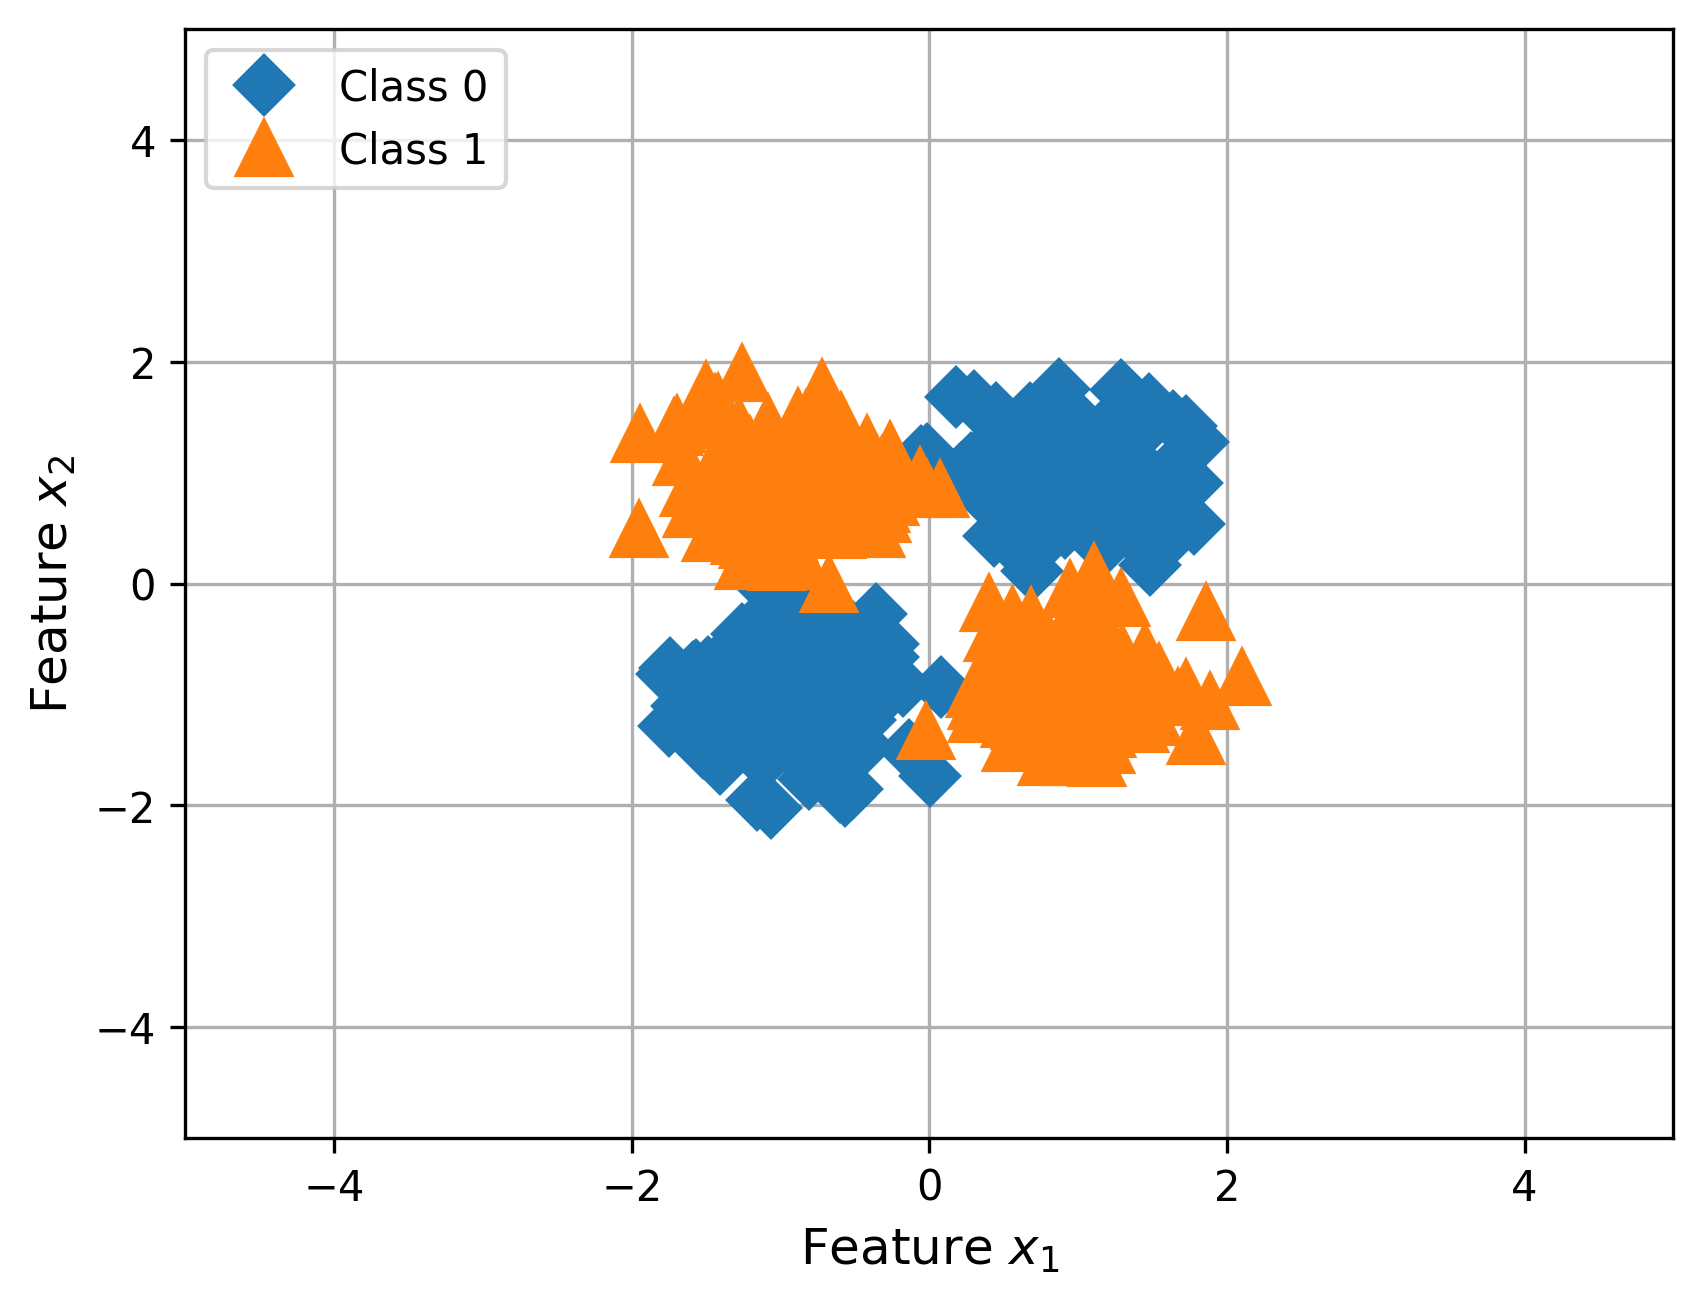

In [9]:
plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

#### Implementing the Model

In [10]:
import torch


class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
                
            # 1st hidden layer
            torch.nn.Linear(num_features, 25),
            torch.nn.ReLU(),

            # 2nd hidden layer
            torch.nn.Linear(25, 15),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(15, num_classes),
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

#### Define the dataloaders

In [11]:
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]        
        return x, y

    def __len__(self):
        return self.labels.shape[0]
    

train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val)
test_ds = MyDataset(X_test, y_test)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=32,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=32,
    shuffle=False,
)

#### The training Loop

In [12]:
def compute_accuracy(model, dataloader):

    model = model.eval()
    
    correct = 0.0
    total_examples = 0
    
    #Iterate over the dataloader
    for idx, (features, labels) in enumerate(dataloader):
        
        #Make predictions with the model
        with torch.inference_mode(): # basically the same as torch.no_grad
            logits = model(features)
        
        #Turn predictions into class labels
        predictions = torch.argmax(logits, dim=1)

        #Count how ofter predictions are correct
        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    #return accuracy
    return correct / total_examples

In [13]:
import torch.nn.functional as F


torch.manual_seed(1)
model = PyTorchMLP(num_features=2, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # Stochastic gradient descent

num_epochs = 10

for epoch in range(num_epochs):
    
    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)
        
        loss = F.cross_entropy(logits, labels) # Loss function
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        ### LOGGING
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
              f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
              f" | Train/Val Loss: {loss:.2f}")
    
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")

Epoch: 001/010 | Batch 000/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 001/018 | Train/Val Loss: 0.69
Epoch: 001/010 | Batch 002/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 003/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 004/018 | Train/Val Loss: 0.69
Epoch: 001/010 | Batch 005/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 006/018 | Train/Val Loss: 0.66
Epoch: 001/010 | Batch 007/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 008/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 009/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 010/018 | Train/Val Loss: 0.66
Epoch: 001/010 | Batch 011/018 | Train/Val Loss: 0.65
Epoch: 001/010 | Batch 012/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 013/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 014/018 | Train/Val Loss: 0.65
Epoch: 001/010 | Batch 015/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 016/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 017/018 | Train/Val Loss: 0.65
Train Acc 68.41% | Val Acc 6

#### Evaluate our model

In [14]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 98.25%
Val Acc 100.00%
Test Acc 99.12%


#### Visualizing the decision boundary

In [21]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('D', '^', 'x', 's', 'v')
    colors = ('C0', 'C1', 'C2', 'C3', 'C4')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits = classifier.forward(tensor)
    Z = np.argmax(logits.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    #edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

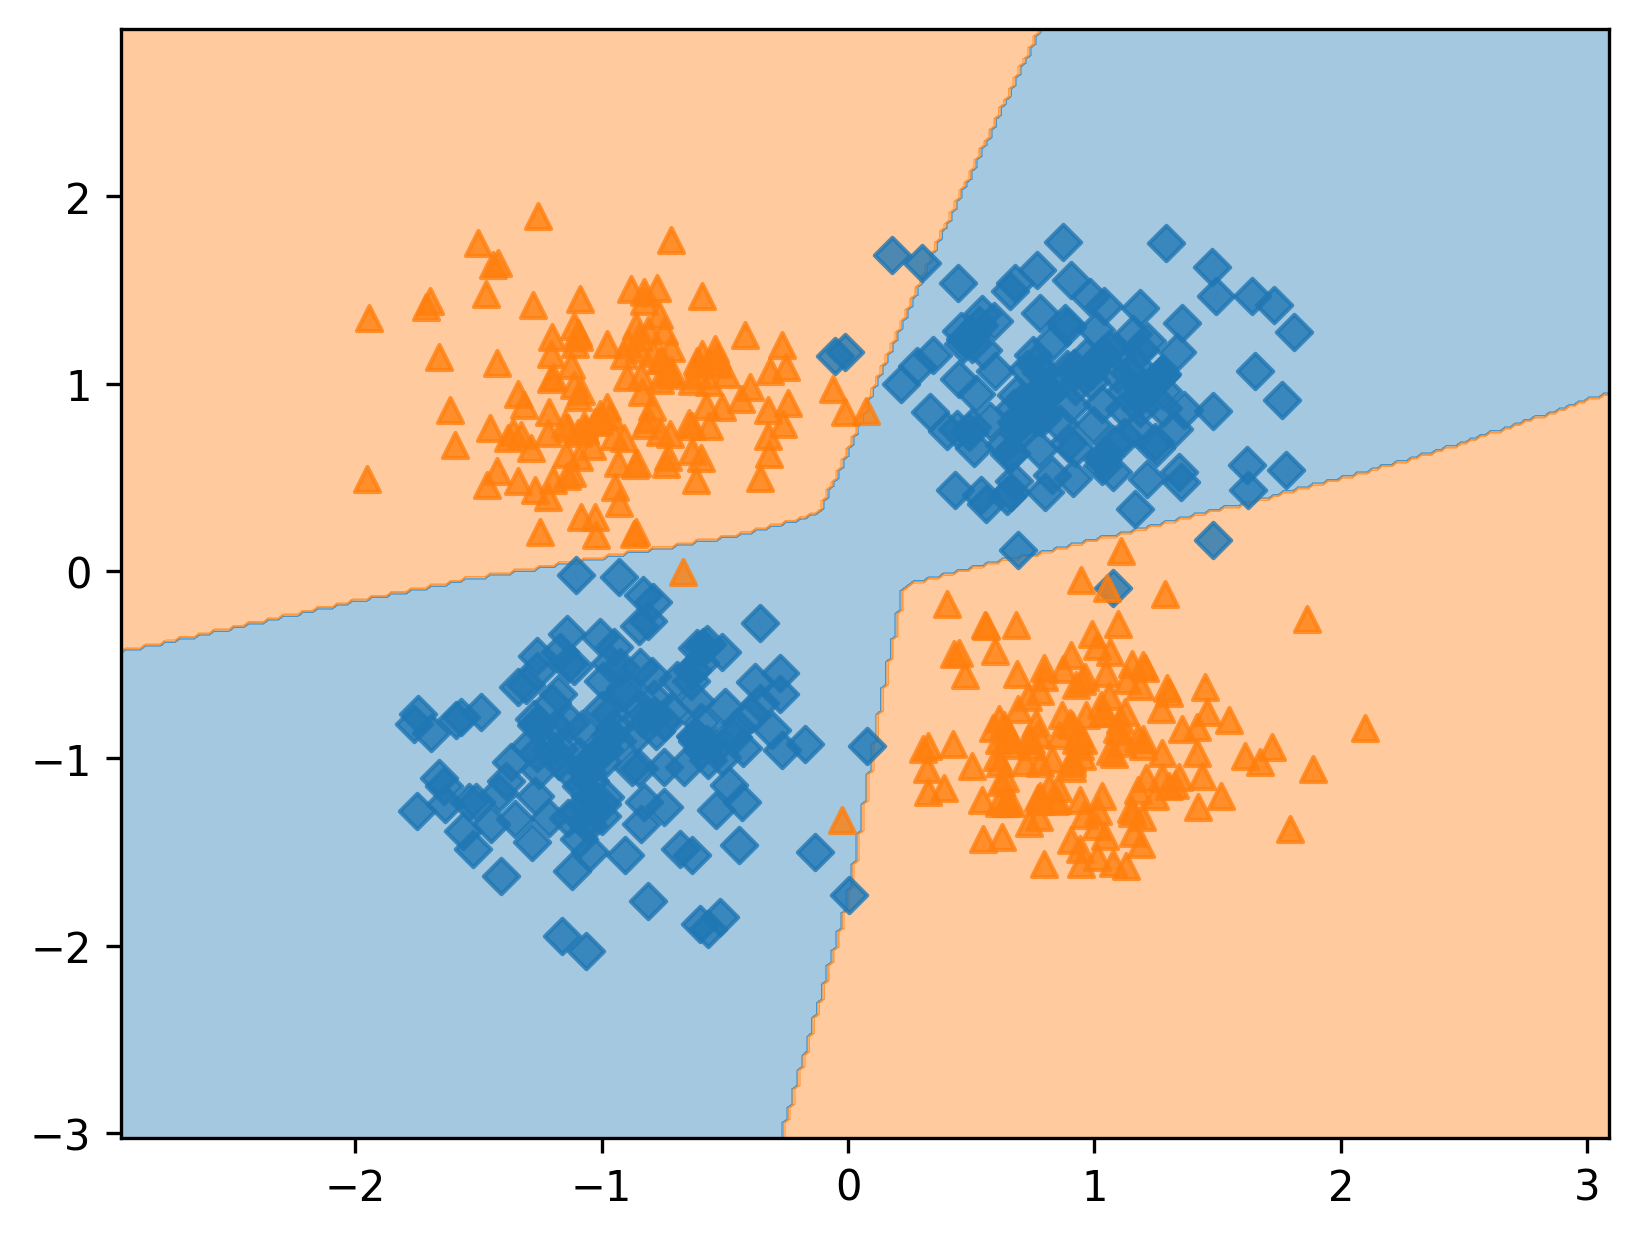

In [22]:
plot_decision_regions(X_train, y_train, classifier=model)